# Run model on fake data

Here, we generate a synthetic data set for purposes of validating the model constructed in Edward.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# we'll want this function below
def softplus(x):
    return np.logaddexp(0, x)

In [3]:
ed.set_seed(12225)

The model is defined by the spike count $N_{us}$ observed when stimulus $s$ is presented to unit $u$:

$$
\begin{align}
N &\sim \mathrm{Poisson}(e^\lambda)  \\
\lambda_{us} &\sim \mathcal{N}(A_{u} + (B \cdot X)_{us}, \sigma^2) \\
\log \sigma &\sim \mathcal{N}(-7, 1^2) \\
\end{align}
$$
With $X$ an $P \times N_s$ matrix of known regressors, $Z$ a $K \times N_s$ matrix of latent binary features
governed by an Indian Buffet Process, $A$ and $N_u$ vector of baselines, and $(\cdot)_+$ the softplus function: 
$(x)_+ = \log(1 + e^x)$.

# Define constants

In [4]:
# basic constants
Nrep = 50  # number of observations per unit per stim
NB = 10  # number of trials in minibatch
NU = 50  # number of units
NS = 50  # number of stims
P = 3  # number of specified regressors
K = 4  # number of latents

# Make neural response coefficients

In [5]:
dA = np.log(softplus(25 + 5 * np.random.randn(NU)))  # baseline
dB = np.log(np.array([0.75, 1.2, 1.5]) + 0.1 * np.random.randn(NU, P))  # regressor effects

# Regressors and latent states

In [6]:
dX = 0.25 * np.random.randn(P, NS)

import scipy.stats as stats

# Generate trial set

In [7]:
dU, dS = np.meshgrid(range(NU), range(NS))
dU = dU.ravel()
dS = dS.ravel()

In [8]:
dlam_mean = np.tile(dA[dU] + np.sum(dB[dU] * dX[:, dS].T, axis=1), Nrep)

dlam = stats.norm.rvs(loc=dlam_mean, scale=0.01)

In [9]:
dcount = stats.poisson.rvs(np.exp(dlam))
dcount.shape

(125000,)

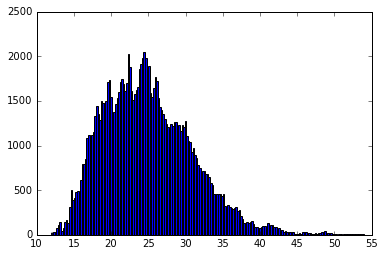

In [10]:
plt.hist(np.exp(dlam), bins=200);

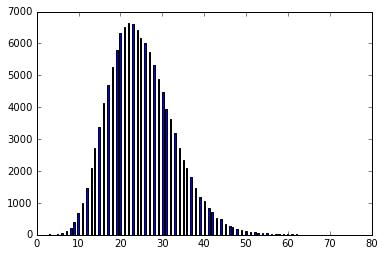

In [11]:
plt.hist(dcount, bins=200);

# Set up data

In [12]:
count = dcount.copy()
Xdat = np.tile(dX[:, dS], (1, Nrep)).T
unit = np.tile(dU, Nrep)
stim = np.tile(dS, Nrep)

# Define the model

## Constants

In [13]:
# define some needed constants
N = Xdat.shape[0]  # number of trials

In [14]:
N

125000

## Inputs and data

In [15]:
X = tf.constant(Xdat.astype('float32'))
U = tf.constant(unit)
S = tf.constant(stim)
counts = tf.constant(count)
allinds = tf.constant(np.arange(N))

In [16]:
X.get_shape()

TensorShape([Dimension(125000), Dimension(3)])

Make a node that produces `NB` indices from the range $[0, N - 1]$. These are the subset of data points we want to use.

In [17]:
batch_inds = np.arange(N)
batch_counts = counts

## Generative (p) model

In [18]:
with tf.variable_scope("pmodel"):
    A = ed.models.Normal(mu=tf.zeros(NU), sigma=5 * tf.ones(NU), name='A')
    B = ed.models.Normal(mu=tf.zeros((NU, P)), sigma=3 * tf.ones((NU, P)), name='B')

    sig = ed.models.Normal(mu=[-7.0], sigma=[1.], name='sig')

    lam_vars = tf.gather(A, U) + tf.reduce_sum(tf.gather(B, U) * X, 1)
    lam = ed.models.Normal(mu=tf.gather(lam_vars, batch_inds), 
                           sigma=tf.exp(sig), name='lam')

    cnt = ed.models.Poisson(lam=tf.exp(lam), value=tf.ones(N), name='cnt')

# Recognition (q) model

In [19]:
with tf.variable_scope("qmodel"):
    q_A = ed.models.NormalWithSoftplusSigma(mu=np.log(25) + tf.Variable(tf.random_normal((NU,))), 
                                            sigma=tf.Variable(tf.random_uniform((NU,))),
                                            name='A')
    tf.scalar_summary('q_A', tf.reduce_mean(q_A.mean()))

    q_B = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, P))), 
                                            sigma=tf.Variable(tf.random_uniform((NU, P))),
                                            name='B')
    tf.scalar_summary('q_B', tf.reduce_mean(q_B.mean()))

    lam_mu = tf.Variable(2 + tf.random_normal((N,)))
    tf.scalar_summary('lam_mu_mean', tf.reduce_mean(tf.gather(lam_mu, batch_inds)))
    lam_sig = tf.Variable(3 * tf.random_uniform((N,)) + 2)
    q_lam = ed.models.NormalWithSoftplusSigma(mu=tf.gather(lam_mu, batch_inds),
                                              sigma=tf.gather(lam_sig, batch_inds),
                                              name='lam')

    q_sig = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(-7. * tf.random_uniform((1,))),
                                              sigma=tf.Variable(tf.random_uniform((1,))),
                                              name='sig')

# Do variational inference

In [20]:
data = {cnt: batch_counts}
inference = ed.KLqp({A: q_A, B: q_B, sig: q_sig, lam: q_lam}, data)

In [21]:
init = tf.initialize_all_variables()

# Notes before inference:

- The `logdir` keyword specifies the place to put the log file (assuming you've instrumented the code to save events, etc.). If a subdirectory is given, pointing Tensorboard at the parent directory allows you to compare across subdirectories (runs).
    - I'm using the `jmp/instrumented` branch of the `jmxpearson/edward` fork
- I had to lower the learning rate in Adam to avoid NaNs early on in learning. Gradient clipping might solve the same problem.
- I'm currently using "all" the data, but this should probably be switched to minibatches.
- I've used `n_samples` = 1, 5, 10, and 25, which all seem pretty similar after 10k iterations. 

In [22]:
inference.run(n_iter=50000, n_print=100, n_samples=1,
              logdir='data/run14',
              optimizer=tf.train.AdamOptimizer(1e-2))
#               scale={lam: N/NB, cnt: N/NB})

Iteration     1 [  0%]: Loss = 41458282496.000
Iteration   100 [  0%]: Loss = 95568658432.000
Iteration   200 [  0%]: Loss = 39306772480.000
Iteration   300 [  0%]: Loss = 29107064832.000
Iteration   400 [  0%]: Loss = 139300061184.000
Iteration   500 [  1%]: Loss = 230833553408.000
Iteration   600 [  1%]: Loss = 8891456512.000
Iteration   700 [  1%]: Loss = 54228299776.000
Iteration   800 [  1%]: Loss = 30593196032.000
Iteration   900 [  1%]: Loss = 29723918336.000
Iteration  1000 [  2%]: Loss = 4598548992.000
Iteration  1100 [  2%]: Loss = 76396339200.000
Iteration  1200 [  2%]: Loss = 2889106944.000
Iteration  1300 [  2%]: Loss = 8476676096.000
Iteration  1400 [  2%]: Loss = 2079582208.000
Iteration  1500 [  3%]: Loss = 15410042880.000
Iteration  1600 [  3%]: Loss = 958369408.000
Iteration  1700 [  3%]: Loss = 222933360.000
Iteration  1800 [  3%]: Loss = 5903687680.000
Iteration  1900 [  3%]: Loss = 13617359872.000
Iteration  2000 [  4%]: Loss = 3490253824.000
Iteration  2100 [  4%]

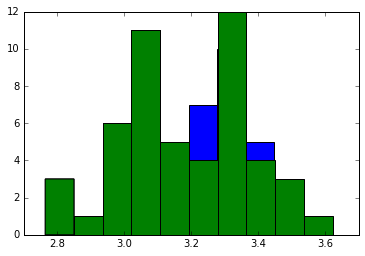

In [23]:
plt.hist(q_A.mean().eval().ravel()); plt.hist(dA.ravel());

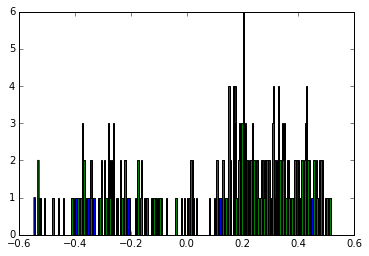

In [24]:
plt.hist(q_B.mean().eval().ravel(), 200), plt.hist(dB.ravel(), 200);

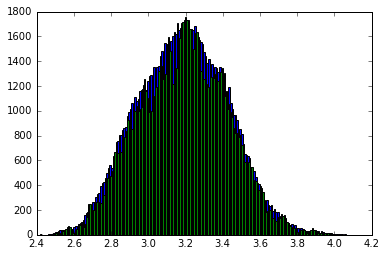

In [25]:
plt.hist(lam_mu.eval(), 200), plt.hist(dlam, 200);

In [26]:
lam_mu.eval()

array([ 3.43366909,  3.37957621,  3.18125939, ...,  3.38823128,
        3.43631458,  3.11984277], dtype=float32)

In [27]:
q_lam.mean().eval()

array([ 3.43366909,  3.37957621,  3.18125939, ...,  3.38823128,
        3.43631458,  3.11984277], dtype=float32)

In [28]:
q_sig.mean().eval()

array([-2.26502538], dtype=float32)